In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
import ast 
import numpy as np
from scipy.spatial import KDTree
import abm.config as config
import imp
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=10)
imp.reload(config)
warnings.filterwarnings('ignore')

d:\Python38\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [ ]:
def read_traj(traj_path):
        input_data = pd.read_csv(traj_path)
        input_data = input_data.dropna()
        if config.INIT_SETTING['parallel']:
            input_data['wether_home'] = input_data['type'].parallel_apply(lambda x: 1 if x=='H_0' else 0)
            input_data['wether_work'] = input_data['type'].parallel_apply(lambda x: 1 if x=='W_0' else 0)
        else:
            input_data['wether_home'] = input_data['type'].apply(lambda x: 1 if x=='H_0' else 0)
            input_data['wether_work'] = input_data['type'].apply(lambda x: 1 if x=='W_0' else 0) 
        input_data.drop(columns=['type'],inplace=True)
        input_data['time'] = pd.to_datetime(input_data['time'])
        starttime = input_data['time'].min()
        input_data = input_data[input_data['time']>=starttime]
        input_data['timestamp'] = (input_data['time']-starttime).dt.total_seconds()/60
        input_data = input_data[~((input_data['timestamp']%(24*60)==0)&(input_data['timestamp']/(24*60)>0))]
        uid_counts = input_data['uid'].value_counts()
        traj_stay_home = uid_counts[uid_counts == 1].index.tolist()
        input_data = input_data[~input_data['uid'].isin(traj_stay_home)]
        return starttime, input_data
starttime, input_data = read_traj('./input/synthetic_data_100000.csv') 
input_data

,time,lat,lon,uid,wether_home,wether_work,timestamp
0,2023-11-12 23:06:21,31.303198,121.578207,0,1,0,6.333333
1,2023-11-13 00:12:16,31.240176,121.492616,0,0,1,72.250000
2,2023-11-13 09:01:11,31.303198,121.578207,0,1,0,601.166667
3,2023-11-13 14:01:52,31.240176,121.492616,0,0,1,901.850000
4,2023-11-13 19:13:26,31.303198,121.578207,0,1,0,1213.416667
...,...,...,...,...,...,...,...
1860451,2023-11-17 19:55:31,31.451261,121.374777,99999,1,0,7015.500000
1860452,2023-11-19 09:01:12,31.439101,121.389183,99999,0,0,9241.183333
1860453,2023-11-19 10:02:57,31.423661,121.430856,99999,0,0,9302.933333
1860454,2023-11-19 16:24:16,31.367463,121.717527,99999,0,0,9684.250000


In [ ]:
import random 
def read_station(home_private_pile_prob, input_data, ev_station=pd.DataFrame(), public_station = pd.DataFrame()):
    ## 初始化私桩
    traj_data = input_data.copy()
    uid_df = traj_data[traj_data['wether_home']==1]['uid'].drop_duplicates()
    uid_df = pd.DataFrame(uid_df)
    uid_df.reset_index(drop=True,inplace=True)
    home_private_pile_series = [random.choices([1,0],weights=[home_private_pile_prob,1-home_private_pile_prob],k=len(uid_df))]
    home_private_pile_series = list(home_private_pile_series[0])
    uid_df['private_pile'] = home_private_pile_series
    # print(uid_df['private_pile'].value_counts()[1],(home_private_pile_series.count(1)))
    traj_data = traj_data.merge(uid_df,on=['uid'],how='left')
    traj_data['private_pile'] = traj_data['private_pile'].fillna(0)
    private_pile_station = traj_data[((traj_data['private_pile']==1)&(traj_data['wether_home']==1))]
    uid_traj_private_pile = traj_data[traj_data['private_pile']==1]['uid'].drop_duplicates()
    uid_station_private = private_pile_station['uid'].drop_duplicates()
    uid_not_in_station = set(uid_traj_private_pile) - set(uid_station_private)
    uid_list = list(uid_not_in_station)
    for u in uid_list:
        traj_data[traj_data['uid']==u]['private_pile'] = 0
    if len(private_pile_station) != 0:
        private_pile_station.drop_duplicates(subset=['uid'],inplace=True)
        private_pile_station = private_pile_station[['uid','lon','lat']]
        private_pile_station['stationId'] = private_pile_station.apply(lambda r: str(int(r['uid']))+'_private',axis=1)
        private_pile_station['capacity'] = 1
        private_pile_station['charge_speed_station'] = 7
        private_pile_station['unit_price'] = 1.77
        private_pile_station['unit_price'] = private_pile_station['unit_price'].apply(lambda x: str([x for i in range(24)]))
        private_pile_station.rename(columns={'lon':'stationLon','lat':"stationLat",'uid':'owner'}, inplace=True)
        private_pile_station['station_type'] = 'private'
    ## 读取ev_station
    if len(ev_station) > 0:
        ev_station['station_type'] = 'public'
        ev_station['owner'] = -1
        
    if len(public_station) > 0:
        public_station['station_type'] = 'public'
        public_station['owner'] = -1
        public_station['charge_speed_station'] = public_station['charge_speed_station'].apply(lambda x: x if x>0 else 7.0)
        public_station.drop(columns=['Unnamed: 0'],inplace=True)
    chargstations = pd.concat([ev_station,public_station,private_pile_station], axis=0)
    # bounds = (120.85, 30.67, 122.24, 31.87)
    # chargstations = chargstations[(chargstations['stationLon']>bounds[0])&(chargstations['stationLon']<bounds[2])
    #                               &(chargstations['stationLat']>bounds[1])&(chargstations['stationLat']<bounds[3])]
    return chargstations, traj_data


#evdata中识别的桩
ev_charge_station = pd.read_csv('./charge_station/evstation.csv')
ev_charge_station.rename(columns={'order':'capacity','lon':'stationLon','lat':"stationLat"},inplace=True)
ev_charge_station['stationId'] = [i for i in range(len(ev_charge_station))]
ev_charge_station['stationId'] = ev_charge_station['stationId'].apply(lambda x: str(x)+'_ev_station')
ev_charge_station = ev_charge_station[['stationId','stationLon','stationLat','capacity']]
ev_charge_station['charge_speed_station'] = 7
ev_charge_station['unit_price'] = 0.3#/ev_charge_station['capacity']
ev_charge_station['unit_price'] = ev_charge_station['unit_price'].apply(lambda x: str([x for i in range(24)]))
ev_charge_station

#公共桩
# public_station = pd.read_csv(r'charge_station/stations_info.csv')

home_private_pile_prob = 340/1310 #340万为全国私桩总量，1310万为全国新能源车总量
chargstations, input_data = read_station(
    home_private_pile_prob=home_private_pile_prob, 
    input_data=input_data, 
    ev_station=ev_charge_station)
    #public_station=public_station)


In [ ]:

import abm.CarAgent as CarAgent
import abm.ChargingStationAgent as ChargingstationAgent
import abm.Environment as Environment 
import imp
from scipy.stats import fatiguelife
import osmnx as ox
import pickle 
import abm.config as config
imp.reload(CarAgent)
imp.reload(ChargingstationAgent)
imp.reload(Environment)
step_length = config.SIM_SETTING['step_length']
step_length

5

In [ ]:
def initialize_station(chargstations,step_length):
    # 初始化充电站
    print('初始化充电站中...')
    station_agent_dict = {}
    for i in range(len(chargstations)):
        r = chargstations.iloc[i]
        station_agent_dict[r['stationId']] = ChargingstationAgent.ChargingStationAgent(
            station_id=r['stationId'],    # 充电站id
            lon=r['stationLon'],               # 经度
            lat=r['stationLat'],                # 纬度
            max_capacity=r['capacity'],              # 最大容量
            charge_speed_station=(r['charge_speed_station']),      # 该充电站最大充电速率 (kW)
            step_length=step_length,      # 每一步的时间长度（分钟）
            unit_price=ast.literal_eval(r['unit_price']),
            station_type=(r['station_type']),
            station_owner=r['owner']
        )
    print('初始化充电站完成，共计', len(station_agent_dict), '个')
    return station_agent_dict

In [ ]:

def initialize_car(input_data,step_length,car_num = None, car_type_per_list = None, car_power_distribution_list = None):
    print('初始化车辆')
    car_agent_dict = {}
    if car_type_per_list == None:
        car_type_per_list = config.SIM_SETTING['car_type_per_list']
    if car_power_distribution_list == None:
        car_power_distribution_list = config.SIM_SETTING['car_power_distribution_list']
    ## 初始化车辆
    carids = input_data['uid'].drop_duplicates()
    car_battery = []
    for i in range(len(car_type_per_list)):
        car_type_per = car_type_per_list[i]
        car_power_distribution = car_power_distribution_list[i]
        car_battery_tmp = []
        for j in range(len(car_power_distribution)-1):
            tmp_list = np.random.randint(car_power_distribution[j],car_power_distribution[j+1],size=int((len(carids)*car_type_per/(len(car_power_distribution)-1))))
            car_battery_tmp.append(tmp_list)
        car_battery_tmp = [item for sublist in car_battery_tmp for item in sublist]
        car_battery.append(car_battery_tmp)
    
    for i in range(len(car_battery)):
        np.random.shuffle(car_battery[i])
    count = 0

    def generate_car(carid,df):
        vehicle_type = np.random.choice([i for i in range(len(car_type_per_list))],p=car_type_per_list)
        total_power = np.random.choice(car_battery[vehicle_type])
        battery_type = 0
        charge_decision_power = fatiguelife.rvs(c = config.SIM_SETTING['low_battery_fat_c'], loc = config.SIM_SETTING['low_battery_fat_loc'], 
                                                scale = config.SIM_SETTING['low_battery_fat_scale'])
        if total_power>= 39 and total_power<53:
            battery_type = 1
            charge_decision_power = fatiguelife.rvs(c = config.SIM_SETTING['mid_battery_fat_c'], loc = config.SIM_SETTING['mid_battery_fat_loc'], 
                                                scale = config.SIM_SETTING['mid_battery_fat_scale'])
        if total_power>=53:
            battery_type = 2
            charge_decision_power = fatiguelife.rvs(c = config.SIM_SETTING['high_battery_fat_c'], loc = config.SIM_SETTING['high_battery_fat_loc'], 
                                                scale = config.SIM_SETTING['high_battery_fat_scale'])
        battery = int(total_power*np.random.randint(20,100)/100)
        
        init_lon = df['lon'].iloc[0]
        init_lat = df['lat'].iloc[0]
        has_private_pile = df['private_pile'].iloc[0]
        tripchain = df[['lon', 'lat', 'timestamp','wether_home','wether_work']].rename(
            columns={'lon': 'lon', 'lat': 'lat', 'timestamp': 'time'}).to_dict(orient='records')
        car_agent = CarAgent.CarAgent(
            carid=carid,                 # 车辆id
            battery=battery,                   # 剩余电量kWh
            init_lon=init_lon,            # 初始经度
            init_lat=init_lat,             # 初始纬度
            tripchain=tripchain[1:],        # 行程链
            step_length=step_length,    # 每一步的时间长度（分钟）
            vehicle_power_type = 0,         #车辆动力类型
            vehicle_type = vehicle_type,  # 车辆类型
            total_power = total_power,   # 总共的电量
            battery_type=battery_type,    # 电池类型
            charge_decision_power=charge_decision_power,
            has_private_pile = has_private_pile,
            consumption_rate=config.SIM_SETTING['consumption_rate'],        # 耗电速率（kwh/100km）
            charge_speed_car=config.SIM_SETTING['charge_speed_car'],         # 该车支持的最大充电速率 (kW)
            travel_speed=config.SIM_SETTING['travel_speed'],            # 该车的行驶速度（km/h）

        )
        return car_agent


    #是否抽样车辆
    
    if car_num == None:
        car_agent_dict = input_data
    else:
        car_agent_dict = pd.merge(input_data,input_data['uid'].drop_duplicates().sample(car_num))

    if config.INIT_SETTING['parallel']:
        from pandarallel import pandarallel
        pandarallel.initialize(progress_bar=True)
        car_agent_dict = car_agent_dict.groupby(['uid']).parallel_apply(lambda df:generate_car(df['uid'].iloc[0],df)).to_dict()
    else:
        car_agent_dict = car_agent_dict.groupby(['uid']).apply(lambda df:generate_car(df['uid'].iloc[0],df)).to_dict()

    print('初始化车辆完成，共计', len(car_agent_dict), '辆')
    return car_agent_dict


In [ ]:
def initialize_environment(car_agent_dict, station_agent_dict, step_length):
    # 初始化环境
    print('初始化环境中...')
    agent_dict = {}
    agent_dict['station'] = station_agent_dict
    agent_dict['car'] = car_agent_dict 
    environment =Environment.EnvironmentAgent(
        config.SIM_SETTING['use_road_network'], 
        agent_dict=agent_dict,
        step_length=step_length,
    )
    print('初始化环境完成')
    return environment

In [ ]:
station_agent_dict = initialize_station(chargstations, step_length)
car_agent_dict = initialize_car(input_data=input_data,step_length=step_length,
                                car_num=100
                                )
environment = initialize_environment(
    car_agent_dict=car_agent_dict,
    station_agent_dict=station_agent_dict,
    step_length=step_length)

# import abm.GridAgent as GridAgent
# environment.all_agents.append(GridAgent.GridAgent())

初始化充电站中...
初始化充电站完成，共计 33772 个
初始化车辆
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


初始化车辆完成，共计 10000 辆
初始化环境中...
初始化环境完成


In [ ]:
# 仿真运行
steps = int(config.SIM_SETTING['simulation_days']*24*60/step_length)

environment.simulate(steps)

========================模型信息========================
仿真步长：5分钟
仿真步数：2016步
仿真天数：7天
车辆数量：10000辆
充电站数量：33772
是否采用路网：False
========================开始仿真========================


正在仿真：: 100%|██████████| 2016/2016 [04:13<00:00,  7.95it/s]


In [ ]:
# 仿真结束，输出结果
output_path = config.OUTPUT_SETTING['output_dir']
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)


# 输出站点信息
station_infos = pd.DataFrame(environment.station_info)
station_infos['time'] = starttime+pd.to_timedelta(station_infos['timestamp'], unit='m')

station_infos['num_current_car'] = station_infos['num_current_car'].fillna(0)
station_infos['num_waiting_car'] = station_infos['num_waiting_car'].fillna(0)
station_infos['num_charge_car_come'] = station_infos['num_charge_car_come'].fillna(0)
station_infos['num_charge_car_left'] = station_infos['num_charge_car_left'].fillna(0)

station_infos.to_csv(f'{output_path}/station_infos.csv', index=False)

In [ ]:

# 车辆信息输出
output_path = config.OUTPUT_SETTING['output_dir']
car_infos = pd.DataFrame(environment.car_info)
car_infos['time'] = pd.to_timedelta(car_infos['timestamp'], unit='m')+starttime

car_infos.sort_values(by=['carid','time'],inplace=True)

car_infos = car_infos[['carid','lon','lat','time','soc','status','current_charge_speed']]
car_infos.to_csv(f'{output_path}/car_infos.csv',index=None)


In [ ]:
# 电网信息输出
grid_infos = pd.DataFrame(environment.grid_info)
grid_infos['time'] = pd.to_timedelta(grid_infos['timestamp'], unit='m')+starttime
grid_infos.to_csv(f'{output_path}/grid_infos.csv',index=None)


<AxesSubplot:xlabel='time'>

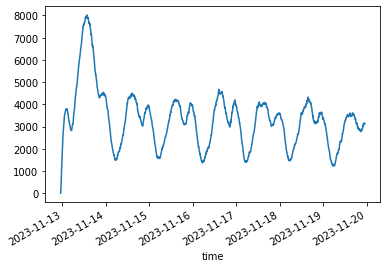

In [ ]:
grid_infos.set_index('time')['current_charge_speed'].plot()

[4]